In [1]:
# Cell 1: Import Libraries and Load Full Data
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import os
import gc
from typing import Dict, List, Tuple, Set
import pickle

# --- Configuration ---
pd.set_option('display.max_columns', None)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# --- Load Data ---
recommendations_path = os.path.join(BASE_DIR, "data/external/recommendations.csv")
games_path = os.path.join(BASE_DIR, "data/external/games_tagged.csv")

# --- Load Full Recommendations Data ---
print(f"Loading recommendations from: {recommendations_path}")
recommendations_pd_full = pd.read_csv(recommendations_path)
recommendations_pd_full['app_id'] = recommendations_pd_full['app_id'].astype(int)
print(f"Loaded {len(recommendations_pd_full):,} full recommendations records.")

# Filter to keep only interactions where the user recommended the game
print(f"\nFiltering recommendations to keep only positive interactions ('is_recommended_binary == 1')...")
original_count = len(recommendations_pd_full)

recommendations_pd_full = recommendations_pd_full[recommendations_pd_full['is_recommended_binary'] == 1].copy()
filtered_count = len(recommendations_pd_full)
print(f"Filtered from {original_count:,} to {filtered_count:,} positive recommendation records.")

# Should be just 1
print(f"Unique values in 'is_recommended_binary' after filtering: {recommendations_pd_full['is_recommended_binary'].unique()}")

# --- Load Game Metadata ---
print(f"\nLoading game metadata from: {games_path}")
games_pd = pd.read_csv(games_path)
games_pd['app_id'] = games_pd['app_id'].astype(int)
print(f"Loaded {len(games_pd):,} games metadata records.")

Loading recommendations from: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\data/external/recommendations.csv
Loaded 41,154,794 full recommendations records.

Filtering recommendations to keep only positive interactions ('is_recommended_binary == 1')...
Filtered from 41,154,794 to 35,304,398 positive recommendation records.
Unique values in 'is_recommended_binary' after filtering: [1]

Loading game metadata from: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\data/external/games_tagged.csv
Loaded 50,872 games metadata records.


In [2]:
# Cell 2: Calculate Interaction Counts on Full Dataset
print("Calculating interaction counts...")

# Count how many interactions each user has
user_interaction_counts = recommendations_pd_full['user_id'].value_counts()

# Count how many interactions each game (app_id) has
item_interaction_counts = recommendations_pd_full['app_id'].value_counts()

print(f"Found {len(user_interaction_counts):,} unique users.")
print(f"Found {len(item_interaction_counts):,} unique items (games) with interactions.")

# Display some stats about the counts
print("\nUser Interaction Count Stats:")
print(user_interaction_counts.describe())
print("\nItem Interaction Count Stats:")
print(item_interaction_counts.describe())

# Example: See the top 5 most active users and most interacted-with games
print("\nTop 5 Users by Interactions:")
print(user_interaction_counts.head())
print("\nTop 5 Items by Interactions:")
print(item_interaction_counts.head())

Calculating interaction counts...
Found 12,663,134 unique users.
Found 37,419 unique items (games) with interactions.

User Interaction Count Stats:
count    1.266313e+07
mean     2.787967e+00
std      6.757650e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.920000e+03
Name: count, dtype: float64

Item Interaction Count Stats:
count     37419.000000
mean        943.488549
std        6725.926600
min           1.000000
25%          10.000000
50%          29.000000
75%         139.000000
max      294879.000000
Name: count, dtype: float64

Top 5 Users by Interactions:
user_id
5112758     3920
5669734     3479
11553593    3392
5390510     3023
1353327     2262
Name: count, dtype: int64

Top 5 Items by Interactions:
app_id
440       294879
252490    226293
292030    193139
431960    186792
730       186306
Name: count, dtype: int64



--- Plotting Distributions (for visual reference) ---


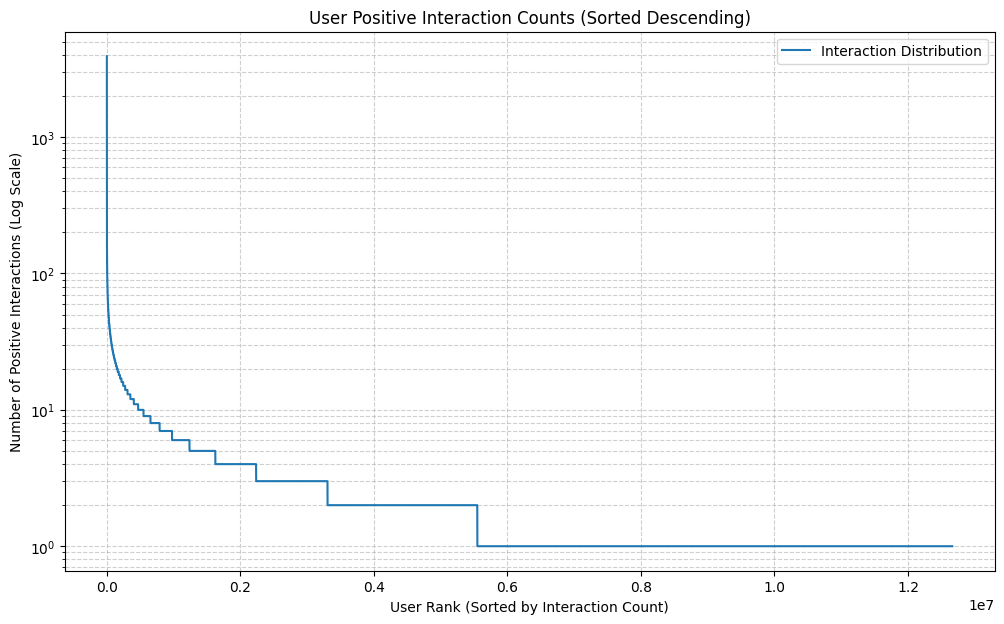

User Percentiles:
0.50     1.0
0.75     3.0
0.90     5.0
0.95     9.0
0.99    22.0
Name: count, dtype: float64


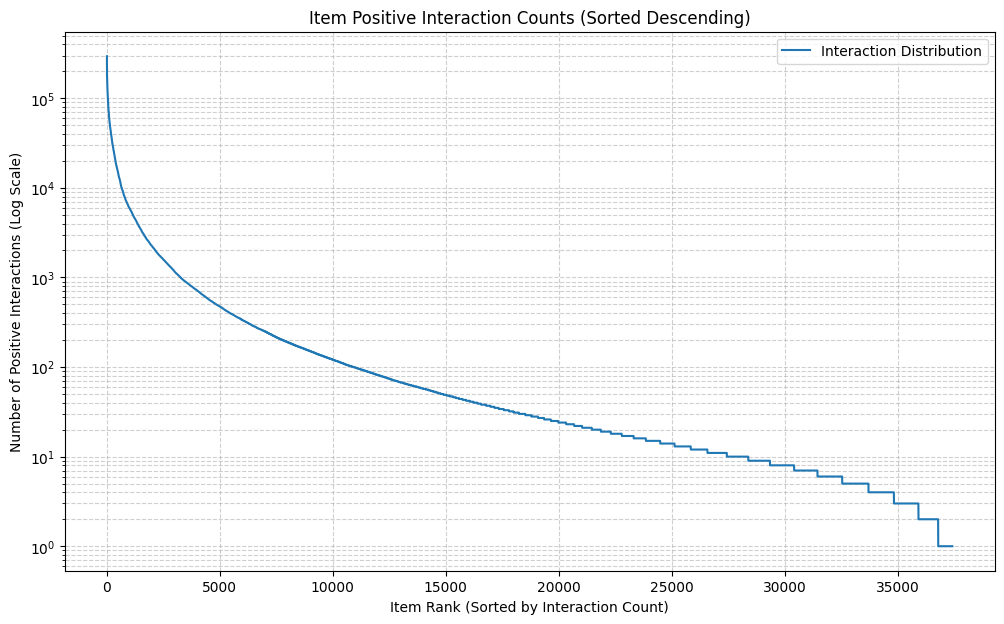

Item Percentiles:
0.50       29.00
0.75      139.00
0.90      797.00
0.95     2476.10
0.99    20194.22
Name: count, dtype: float64


In [3]:
# Cell 2b: Explore Elbow Points with Varying Sensitivity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Function to Plot Distribution ---
def plot_interaction_distribution(counts_series, entity_name, highlight_rank=None, highlight_threshold=None, S_value=None):
    """Plots the interaction distribution"""
    if counts_series.empty:
        print(f"Cannot plot for {entity_name}: Series is empty.")
        return

    sorted_counts = counts_series[counts_series > 0].sort_values(ascending=False).reset_index(drop=True)
    if sorted_counts.empty:
        print(f"Cannot plot for {entity_name}: No positive counts.")
        return

    ranks = np.arange(1, len(sorted_counts) + 1)
    count_values = sorted_counts.values

    plt.figure(figsize=(12, 7))
    plt.plot(ranks, count_values, label='Interaction Distribution')
    title = f'{entity_name} Positive Interaction Counts (Sorted Descending)'
    plt.title(title)
    plt.xlabel(f'{entity_name} Rank (Sorted by Interaction Count)')
    plt.ylabel('Number of Positive Interactions (Log Scale)')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.6)

    plt.legend()
    plt.show()
 
print("\n--- Plotting Distributions (for visual reference) ---")
# Plot the raw distributions without highlighting any specific elbow initially
plot_interaction_distribution(user_interaction_counts, 'User')
print("User Percentiles:")
print(user_interaction_counts.quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

plot_interaction_distribution(item_interaction_counts, 'Item')
print("Item Percentiles:")
print(item_interaction_counts.quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

In [4]:
# Cell 3: Filter Interactions Based on Thresholds

# --- Define Thresholds ---
MIN_USER_INTERACTIONS = 9
MIN_ITEM_INTERACTIONS = 2476

print(f"\nFiltering criteria: Users >= {MIN_USER_INTERACTIONS} interactions, Items >= {MIN_ITEM_INTERACTIONS} interactions.")

# --- Filter Users ---
# Get the list of user_ids who meet the minimum interaction count
users_to_keep = user_interaction_counts[user_interaction_counts >= MIN_USER_INTERACTIONS].index
# Filter the main dataframe
recommendations_pd_filtered_users = recommendations_pd_full[recommendations_pd_full['user_id'].isin(users_to_keep)]
print(f"Interactions after user filtering: {len(recommendations_pd_filtered_users):,}")

# --- Filter Items ---
# Get the list of app_ids that meet the minimum interaction count
items_to_keep = item_interaction_counts[item_interaction_counts >= MIN_ITEM_INTERACTIONS].index
# Filter the dataframe that was already filtered by user
recommendations_pd_filtered = recommendations_pd_filtered_users[recommendations_pd_filtered_users['app_id'].isin(items_to_keep)]
print(f"Interactions after item filtering: {len(recommendations_pd_filtered):,}")

# --- Cleanup intermediate variables ---
del users_to_keep
del items_to_keep
del user_interaction_counts
del item_interaction_counts
del recommendations_pd_filtered_users
del recommendations_pd_full

gc.collect()


Filtering criteria: Users >= 9 interactions, Items >= 2476 interactions.
Interactions after user filtering: 12,148,447
Interactions after item filtering: 9,297,282


13842

In [5]:
# Cell 4: Shuffle Filtered Data (No Sampling, Just Shuffle)

SEED = 42 # For reproducible results

print(f"\nFiltered interaction count: {len(recommendations_pd_filtered):,}")
print("Shuffling the filtered data...")
# Shuffle all rows using sample(frac=1) instead of sampling a subset
recommendations_pd_final = recommendations_pd_filtered.sample(frac=1, random_state=SEED)

print(f"Final number of interactions being used (shuffled): {len(recommendations_pd_final):,}")

# --- Cleanup intermediate variable ---
del recommendations_pd_filtered
gc.collect()


Filtered interaction count: 9,297,282
Shuffling the filtered data...
Final number of interactions being used (shuffled): 9,297,282


0

In [6]:
# Cell 5: Display Sample Data and Finalize Game Metadata

print("\nSample Final Recommendations Data (Filtered & Shuffled):")
print(recommendations_pd_final.head())

# Get unique game IDs from the final interaction dataset
final_game_ids = recommendations_pd_final['app_id'].unique()
print(f"\nUnique Games in final dataset: {len(final_game_ids):,}")

print("\nFiltering Games Metadata...")
# Keep only metadata for games present in the final interaction data
games_pd_filtered = games_pd[games_pd['app_id'].isin(final_game_ids)]
print(f"Retained metadata for {len(games_pd_filtered):,} games.")

print("\nSample Filtered Games Metadata (Relevant Columns):")
print(games_pd_filtered[['app_id', 'title', 'tags']].head())

# --- Final Cleanup for this Stage ---
games_pd = games_pd_filtered

# Delete the intermediate filtered variable and the IDs list
del games_pd_filtered
del final_game_ids
gc.collect()


Sample Final Recommendations Data (Filtered & Shuffled):
           app_id  helpful  funny  user_id  review_id  hours_log  \
9018745    203770        0      0  4713301    9018745   4.188138   
14930726   207610       12      0  4243479   14930726   2.772589   
4010558   1172470        0      0  3066200    4010558   1.648659   
225601     526870        0      0   485854     225601   3.740048   
22490204   105600        0      0  1153037   22490204   5.354698   

          hours_log_scaled  is_recommended_binary  review_year  review_month  \
9018745           0.479441                      1         2018             6   
14930726         -0.371998                      1         2017             9   
4010558          -1.048030                      1         2021             3   
225601            0.209919                      1         2021            11   
22490204          1.181114                      1         2022             9   

          review_day  review_age_years  helpfulness_

0

In [7]:
# Cell 6: Create User-Item Interaction Matrix

print("Creating the User-Item interaction matrix...")
print(f"Input data shape: {recommendations_pd_final.shape}")

# Define the interaction value column
interaction_value_col = 'hours_log_scaled'

# Use pivot_table to create the matrix (Users as rows, Items as columns)
user_item_pivot = recommendations_pd_final.pivot_table(
    index='user_id',
    columns='app_id',
    values=interaction_value_col,
    fill_value=0  # Fill missing interactions (NaN) with 0
)

print(f"Created pivot table with shape: {user_item_pivot.shape} (Users x Items)")

# Convert the dense pivot table to a sparse matrix (CSR format)
print("Converting pivot table to sparse matrix (CSR format)...")
user_item_sparse_matrix = csr_matrix(user_item_pivot.values)

# --- Create Mappings for Interpretation ---
# These maps are essential to link matrix rows/columns back to original IDs
item_map = {id: i for i, id in enumerate(user_item_pivot.columns)} # Needed later

# Create inverse mappings to get IDs from matrix indices
item_map_inv = {i: id for id, i in item_map.items()} # Needed later

print(f"Sparse matrix shape: {user_item_sparse_matrix.shape}")
sparsity = 1.0 - user_item_sparse_matrix.nnz / (user_item_sparse_matrix.shape[0] * user_item_sparse_matrix.shape[1])
print(f"Sparsity: {sparsity:.4%}")

# --- Cleanup ---
del user_item_pivot

gc.collect()

Creating the User-Item interaction matrix...
Input data shape: (9297282, 15)
Created pivot table with shape: (651948, 1872) (Users x Items)
Converting pivot table to sparse matrix (CSR format)...
Sparse matrix shape: (651948, 1872)
Sparsity: 99.2382%


0

In [8]:
# Cell 7: Calculate Item-Item Cosine Similarity

print("Calculating Item-Item cosine similarity...")

# Important: cosine_similarity expects samples as rows.
# To calculate item-item similarity, we transpose the matrix (.T) so that items become rows.
item_user_sparse_matrix = user_item_sparse_matrix.T

# Calculate cosine similarity between all pairs of items
item_similarity_matrix = cosine_similarity(item_user_sparse_matrix, dense_output=True) # Keep dense

print(f"Calculated item-item similarity matrix with shape: {item_similarity_matrix.shape}")

# Verify the diagonal is all 1s
print(f"Diagonal check (should be close to 1): {item_similarity_matrix.diagonal().mean()}")

# Display a small slice
print("\nSlice of the similarity matrix:")
print(pd.DataFrame(item_similarity_matrix).iloc[:5, :5])

# --- Cleanup ---
del item_user_sparse_matrix
del user_item_sparse_matrix

gc.collect()

Calculating Item-Item cosine similarity...
Calculated item-item similarity matrix with shape: (1872, 1872)
Diagonal check (should be close to 1): 0.9999999999999998

Slice of the similarity matrix:
          0         1         2         3         4
0  1.000000  0.042286  0.050347  0.034967  0.025199
1  0.042286  1.000000  0.204617  0.165443  0.145375
2  0.050347  0.204617  1.000000  0.145984  0.190362
3  0.034967  0.165443  0.145984  1.000000  0.106127
4  0.025199  0.145375  0.190362  0.106127  1.000000


0

In [9]:
# Cell 8: Define Item-Based Recommendation Function using Cosine Similarity

def recommend_similar_games_cosine(target_app_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Recommends games similar to the target_app_id using the pre-calculated
    item-item cosine similarity matrix. Requires 'item_map', 'item_map_inv',
    'item_similarity_matrix', and 'games_pd' to be in the global scope or passed explicitly.

    Args:
        target_app_id: The app_id of the game for which to find recommendations.
        top_n: The number of similar games to return.

    Returns:
        A pandas DataFrame containing the top_n recommended games, including
        their app_id, game_name, and similarity_score. Returns an empty
        DataFrame if the target_app_id is not found in the model's data.
    """
    # --- Input Validation ---
    if target_app_id not in item_map:
        print(f"Warning: app_id {target_app_id} not found in the filtered interaction data.")
        return pd.DataFrame(columns=['app_id', 'game_name', 'similarity_score'])

    # --- Get Matrix Index ---
    try:
        item_index = item_map[target_app_id]
    except KeyError:
        print(f"Error: Could not find matrix index for app_id {target_app_id}.")
        return pd.DataFrame(columns=['app_id', 'game_name', 'similarity_score'])

    # --- Retrieve Similarity Scores ---
    similarity_scores = item_similarity_matrix[item_index]

    # --- Combine Scores with Item Indices ---
    item_score_pairs = list(enumerate(similarity_scores))

    # --- Sort by Similarity ---
    sorted_item_score_pairs = sorted(item_score_pairs, key=lambda x: x[1], reverse=True)

    # --- Exclude Input Game & Select Top N ---
    top_similar_items = sorted_item_score_pairs[1 : top_n + 1]

    # --- Map Indices back to App IDs and Get Names ---
    recommendations = []
    for matrix_idx, score in top_similar_items:
        try:
            recommended_app_id = item_map_inv[matrix_idx]
            game_info = games_pd[games_pd['app_id'] == recommended_app_id]
            game_name = game_info['title'].iloc[0] if not game_info.empty else "Title Not Found"
            recommendations.append({
                'app_id': recommended_app_id,
                'game_name': game_name,
                'similarity_score': score
            })
        except (KeyError, IndexError) as e:
             print(f"Warning: Error processing recommendation index {matrix_idx}: {e}")

    return pd.DataFrame(recommendations)

# --- Quick Test ---
if 'item_map' in globals() and item_map:
    # Use a known good ID from your filtered set if possible, otherwise pick one
    test_id_options = list(item_map.keys())
    if test_id_options:
         test_id = test_id_options[4] # Example: Pick 5th game ID
         print(f"\n--- Testing recommendation function with app_id: {test_id} ---")
         # Look up name for context
         test_name = games_pd.loc[games_pd['app_id'] == test_id, 'title'].iloc[0] if not games_pd[games_pd['app_id'] == test_id].empty else "N/A"
         print(f"--- Target Game: {test_name} ---")
         sample_recommendations = recommend_similar_games_cosine(test_id, top_n=10)
         print(sample_recommendations.to_string(index=False)) # Print without index
    else:
        print("Skipping function test as item_map is empty.")
else:
    print("Skipping function test as item_map is not available.")


--- Testing recommendation function with app_id: 60 ---
--- Target Game: Ricochet ---
 app_id                      game_name  similarity_score
     30                  Day of Defeat          0.190362
     20          Team Fortress Classic          0.145375
     50      Half-Life: Opposing Force          0.106127
    130          Half-Life: Blue Shift          0.104673
    280              Half-Life: Source          0.096857
    340        Half-Life 2: Lost Coast          0.092275
    320        Half-Life 2: Deathmatch          0.088270
     80 Counter-Strike: Condition Zero          0.077348
    300          Day of Defeat: Source          0.069868
    380       Half-Life 2: Episode One          0.067546


In [10]:
# Cell 9: Save Model Artifacts for Streamlit App

print("\nSaving model artifacts...")

# Define filenames for the artifacts
similarity_matrix_filename = "item_similarity_matrix.pkl"
item_map_filename = "item_map.pkl"
item_map_inv_filename = "item_map_inv.pkl"
games_df_filename = "filtered_games_metadata.pkl"

# Define the target directory
models_dir = os.path.join(BASE_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

# --- Save Objects ---
# 1. Item-Item Cosine Similarity Matrix
similarity_matrix_path = os.path.join(models_dir, similarity_matrix_filename)
with open(similarity_matrix_path, 'wb') as f:
    pickle.dump(item_similarity_matrix, f)
print(f"Saved item similarity matrix to: {similarity_matrix_path}")

# 2. Item Map (app_id -> matrix index)
item_map_path = os.path.join(models_dir, item_map_filename)
with open(item_map_path, 'wb') as f:
    pickle.dump(item_map, f)
print(f"Saved item map to: {item_map_path}")

# 3. Inverse Item Map (matrix index -> app_id)
item_map_inv_path = os.path.join(models_dir, item_map_inv_filename)
with open(item_map_inv_path, 'wb') as f:
    pickle.dump(item_map_inv, f)
print(f"Saved inverse item map to: {item_map_inv_path}")

# 4. Filtered Games DataFrame
games_df_path = os.path.join(models_dir, games_df_filename)
with open(games_df_path, 'wb') as f:
    pickle.dump(games_pd, f)
print(f"Saved filtered games metadata DataFrame to: {games_df_path}")


Saving model artifacts...
Saved item similarity matrix to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_similarity_matrix.pkl
Saved item map to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_map.pkl
Saved inverse item map to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_map_inv.pkl
Saved filtered games metadata DataFrame to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\filtered_games_metadata.pkl


In [11]:
# Cell 10: Create Train-Test Split for Evaluation

print("\nPerforming train-test split...")

# --- Parameters ---
test_fraction = 0.2 # Fraction of interactions per user to hold out for testing
min_train_interactions = 9 # Minimum interactions a user must have in the training set

# --- Split Data ---
test_indices = recommendations_pd_final.groupby('user_id').sample(frac=test_fraction, random_state=SEED).index
train_indices = recommendations_pd_final.index.difference(test_indices)

train_df = recommendations_pd_final.loc[train_indices]
test_df = recommendations_pd_final.loc[test_indices]

print(f"Original interactions: {len(recommendations_pd_final):,}")
print(f"Training interactions: {len(train_df):,}")
print(f"Testing interactions:  {len(test_df):,}")

# --- Create User-to-Items Mappings ---
train_items_map: Dict[int, Set[int]] = train_df.groupby('user_id')['app_id'].apply(set)
test_items_map: Dict[int, Set[int]] = test_df.groupby('user_id')['app_id'].apply(set)

print(f"\nUsers in training map: {len(train_items_map):,}")
print(f"Users in testing map:  {len(test_items_map):,}")

# --- Filter Test Users ---
valid_test_user_ids = {
    user_id for user_id, train_items in train_items_map.items()
    if user_id in test_items_map and len(train_items) >= min_train_interactions
}

# Filter the test map
filtered_test_items_map = {
    user_id: items for user_id, items in test_items_map.items()
    if user_id in valid_test_user_ids
}

print(f"Valid users for evaluation: {len(valid_test_user_ids):,}")

# --- Cleanup ---
del test_indices
del train_indices
del test_df 
del train_df
del recommendations_pd_final
gc.collect()


Performing train-test split...
Original interactions: 9,297,282
Training interactions: 7,426,467
Testing interactions:  1,870,815

Users in training map: 651,948
Users in testing map:  648,281
Valid users for evaluation: 348,481


0

In [12]:
# Cell 11: User Recommendation Function (for Evaluation)

def recommend_for_user(
    user_id: int,
    k: int,
    train_items_map: Dict[int, Set[int]],
    item_similarity_matrix: np.ndarray,
    item_map: Dict[int, int],
    item_map_inv: Dict[int, int]
) -> List[int]:
    """
    Generates top K recommendations for a user based on their training interactions
    using the item-item similarity matrix.
    """
    if user_id not in train_items_map or not train_items_map[user_id]:
        return []

    user_train_app_ids = train_items_map[user_id]
    n_items = item_similarity_matrix.shape[0]
    aggregated_scores = np.zeros(n_items)

    user_train_indices = {item_map[app_id] for app_id in user_train_app_ids if app_id in item_map}

    if not user_train_indices:
        return []

    for train_idx in user_train_indices:
        if 0 <= train_idx < n_items:
             aggregated_scores += item_similarity_matrix[train_idx]

    candidate_items = []
    for item_idx in range(n_items):
        if item_idx not in user_train_indices and item_idx in item_map_inv:
             candidate_items.append((item_idx, aggregated_scores[item_idx]))

    candidate_items.sort(key=lambda x: x[1], reverse=True)

    recommended_app_ids = [item_map_inv[item_idx] for item_idx, score in candidate_items[:k]]

    return recommended_app_ids

In [13]:
# Cell 12: Evaluation Metric Functions

def precision_at_k(recommended_items: List[int], actual_items: Set[int], k: int) -> float:
    """Calculates Precision@K."""
    if k == 0: return 0.0
    top_k_recs = recommended_items[:k]
    hits = len(set(top_k_recs) & actual_items)
    return hits / k

def recall_at_k(recommended_items: List[int], actual_items: Set[int], k: int) -> float:
    """Calculates Recall@K."""
    if not actual_items: return 0.0
    top_k_recs = recommended_items[:k]
    hits = len(set(top_k_recs) & actual_items)
    return hits / len(actual_items)

In [14]:
# Cell 13: Run Evaluation

print("\nRunning evaluation...")

# --- Evaluation Parameters ---
K = 20

# --- Store Results ---
all_precisions = []
all_recalls = []

# --- Iterate Through Test Users ---
num_evaluated = 0
total_users_to_evaluate = len(valid_test_user_ids)
print(f"Evaluating {total_users_to_evaluate:,} users...")

for i, user_id in enumerate(valid_test_user_ids):
    actual_items = filtered_test_items_map.get(user_id, set())
    if not actual_items: continue

    recommended_ids = recommend_for_user(
        user_id=user_id, k=K, train_items_map=train_items_map,
        item_similarity_matrix=item_similarity_matrix,
        item_map=item_map, item_map_inv=item_map_inv
    )

    precision = precision_at_k(recommended_ids, actual_items, K)
    recall = recall_at_k(recommended_ids, actual_items, K)

    all_precisions.append(precision)
    all_recalls.append(recall)
    num_evaluated += 1

    # Print progress
    if (i + 1) % 5000 == 0 or (i + 1) == total_users_to_evaluate:
        print(f"  Evaluated {i + 1}/{total_users_to_evaluate} users...")

# --- Calculate Average Metrics ---
if num_evaluated > 0:
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)

    print(f"\n--- Evaluation Results (K={K}) ---")
    print(f"Evaluated users: {num_evaluated:,}")
    print(f"Average Precision@{K}: {avg_precision:.4f}")
    print(f"Average Recall@{K}:    {avg_recall:.4f}")
else:
    print("No valid users found to evaluate.")

gc.collect()


Running evaluation...
Evaluating 348,481 users...
  Evaluated 5000/348481 users...
  Evaluated 10000/348481 users...
  Evaluated 15000/348481 users...
  Evaluated 20000/348481 users...
  Evaluated 25000/348481 users...
  Evaluated 30000/348481 users...
  Evaluated 35000/348481 users...
  Evaluated 40000/348481 users...
  Evaluated 45000/348481 users...
  Evaluated 50000/348481 users...
  Evaluated 55000/348481 users...
  Evaluated 60000/348481 users...
  Evaluated 65000/348481 users...
  Evaluated 70000/348481 users...
  Evaluated 75000/348481 users...
  Evaluated 80000/348481 users...
  Evaluated 85000/348481 users...
  Evaluated 90000/348481 users...
  Evaluated 95000/348481 users...
  Evaluated 100000/348481 users...
  Evaluated 105000/348481 users...
  Evaluated 110000/348481 users...
  Evaluated 115000/348481 users...
  Evaluated 120000/348481 users...
  Evaluated 125000/348481 users...
  Evaluated 130000/348481 users...
  Evaluated 135000/348481 users...
  Evaluated 140000/34848

0